# Определение возраста покупателей по фотографии для сети супермаркетов «Хлеб-Соль»

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для определения приблизительного возраста клиентов по их фотографиям, сделанным в прикассовой зоне. 

Цель данного проекта — построить и обучить нейронную сеть, которая сможет определять возраст человека по его фотографии.

В рамках данного проекта будет решаться задача регрессии методом обучения с учителем.

**Описание данных**

Данные для проекта предоставлены сайтом ChaLearn Looking at People и представляют собой папку с изображениями и таблицу с двумя колонками:
* `file_name` - имя файла с изображением
* `real_age` - возраст - целеой признак.

**Краткий план работы:**
1. Исследовательский анализ данных
3. Обучение модели.
3. Анализ обученной модели.
4. Общий вывод.

Применение модели, построенной в этом проекте, позволит более точно анализировать покупательские предпочтения в зависимости от возраста и предлагать релевантные товары, а также контролировать продажу алкоголя.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
SEED = 6885
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Откроем таблицу и выведем на экран первые 5 строк.

In [4]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выясним особенности типов данных и содержимого столбцов.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датафрейм состоит из 7591 наблюдений. Пропусков не обнаружено.

Вычислим основные статистические характеристики.

In [6]:
df.describe()

,real_age
count,"7,591.00"
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


Набор данных включает фотографий людей в возрасте от 1 года до 100 лет. Средний возраст - 31 год, первый квантиль равен 20, а третий - 41. Это свидетельствует о том, что набор данных содержит преимущественно фотографии взрослых людей, тогда как дети и пожилые люди представлены в меньшей степени.

Построим графики распределения возраста.

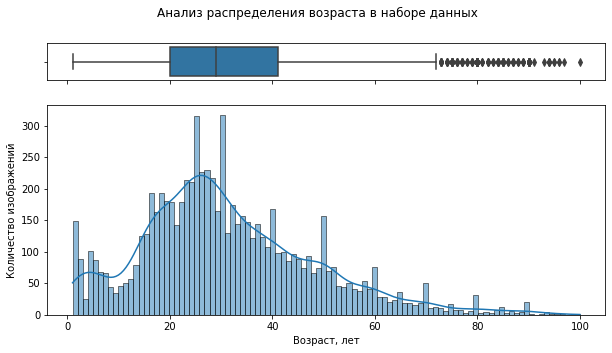

In [7]:
# создание двух объектов с идентичным масштабом оси X (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)}, 
                                    figsize=(10, 5))
f.suptitle('Анализ распределения возраста в наборе данных')

# построение графиков 
sns.boxplot(df["real_age"], orient="h", ax=ax_box)
sns.histplot(df["real_age"], bins=100, kde=True, ax=ax_hist)
 
ax_box.set(xlabel='')
ax_hist.set(xlabel='Возраст, лет', ylabel="Количество изображений")

plt.show()

Распределение имеет правостороннюю асимметрию. Наблюдается несколько пиков: наибольший приходится на возраст примерно 25 лет, далее пики соответствуют "круглым" датам (30, 40 и т.д. лет). Для детских фотографий пик приходится на 1 год.

Построим график, который покажет, какая часть изображений приходится на каждую возрастную группу: детей, подростков, взрослых и пожилых людей.

In [8]:
labels=['child', 'teen', 'adult', 'senior']
df['age_group'] = pd.cut(df['real_age'], bins=[0, 12, 18, 60, 100], labels=labels)
age_group_counts = df['age_group'].value_counts()

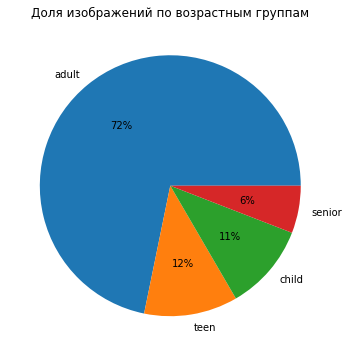

In [9]:
plt.figure(figsize=(10, 6))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%.0f%%')
plt.title('Доля изображений по возрастным группам')
plt.show()

Согласно визуальному анализу, набор данных почти на 3/4 состоит из фотографий взрослых людей, количество детей и подростков примерно одинаково (чуть больше 10 %), а изображений пожилых людей меньше всего (6%).

Выведем на экран 15 случайных фотографий.

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=SEED)

Found 7591 validated image filenames.


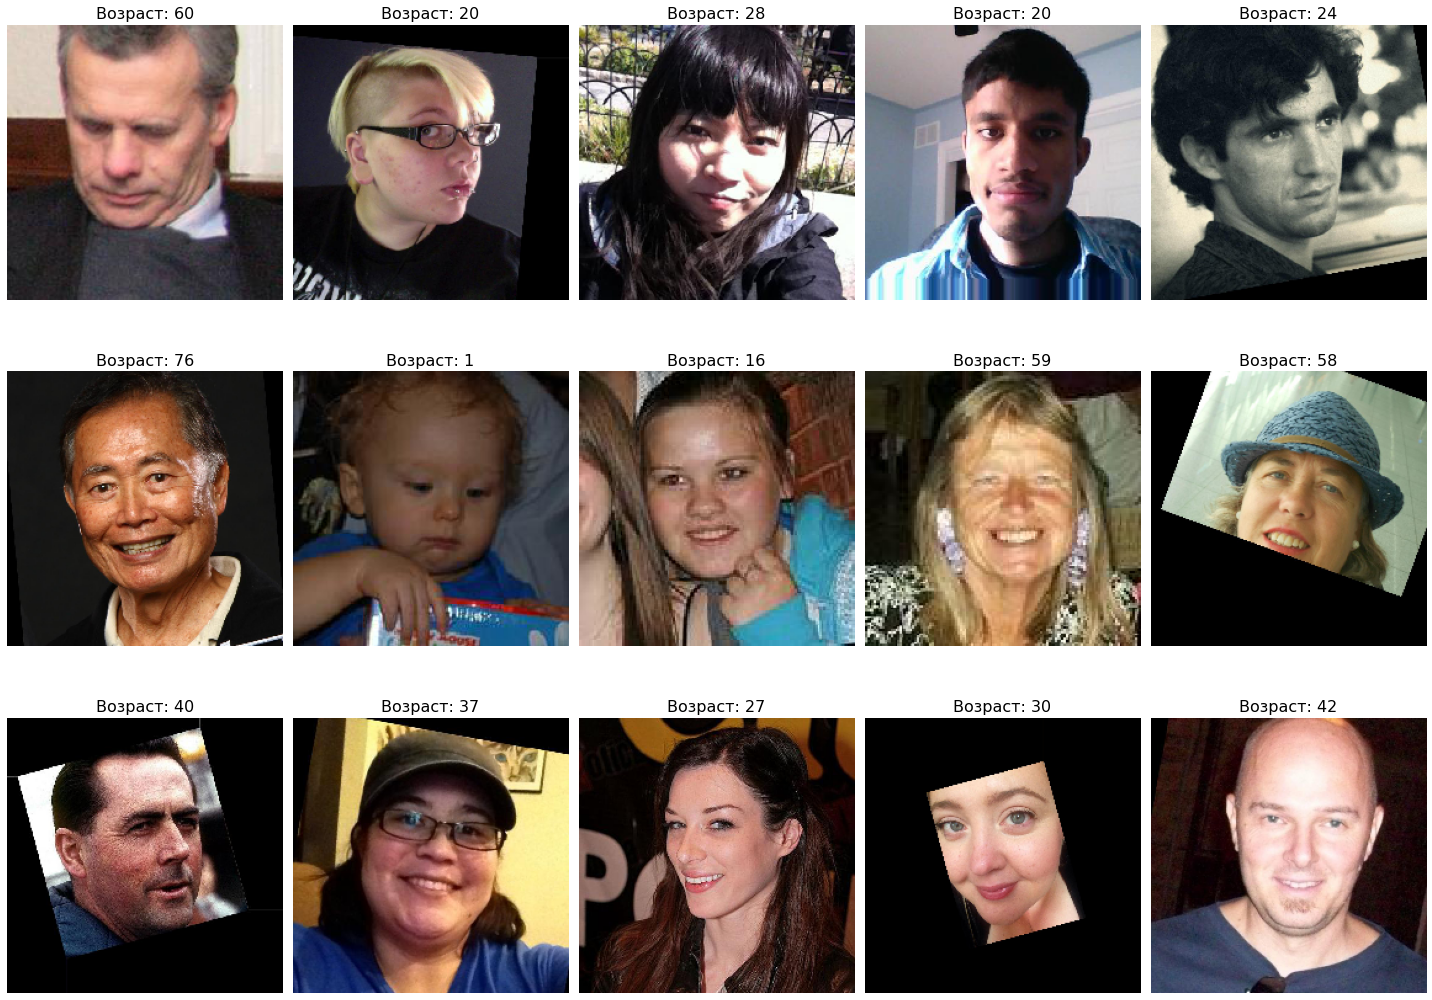

In [11]:
plt.figure(figsize=(20, 15))
for i in range(15):
    img, age = gen_flow.next()
    ax = plt.subplot(3, 5, i + 1) 
    plt.imshow(img[0])  
    plt.title(f'Возраст: {int(age[0])}', fontsize=16)  
    plt.axis('off')  
plt.tight_layout() 
plt.show()

Визуальный анализ изображений позволяет сделать следующие выводы:

* В наборе встречаются как цветные так и черно-белые фотографии. 
* Лица находятся в центре кадра, сняты анфас или в неполный профиль.
* Фотографии выполнены в разных условиях освещенности и под разными углами наклона камеры.
* К части изображений применен поворот, вероятно для выравнивания головы по вертикали.
* На некоторых снимках присутствуют аксессуары, предметы повседневного обихода и части лиц других людей.
* Фон фотографий разнообразен: однородный, неоднородный или размытый.

**Выводы:**
* Данные, предоставленные для анализа представляют собой набор из 7591 изображения и таблицы, в которой указаны имя файла и возраст человека, запечатленного на снимке. 
* Пропусков в таблице не обнаружено.
* Хотя на фотографиях запечатлены люди в возрасте от 1 года до 100 лет, в основном это фотографии взрослых (72%). Детей, подростков и пожилых людей на снимках представлено гораздо меньше: 11%, 12% и 6%. Это может привести к тому, что для этих возрастных групп предсказания будут менее точными.
* Количество изображений недостаточно для полноценного обучения нейронной сети "с нуля", в связи с чем следует использовать предобученную модель, например, ResNet50 с весами "ImageNet".
* В качестве метода аугментации целесообразно использовать повороты в пределах 45 градусов и небольшие искажения перспектив.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Объявим функции для загрузки обучающей и тестовой выборок, а так же создания и обучения модели. Соотношение размеров выборок составляет 4:1.

```python
def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, 
                                 rotation_range=45,
                                 height_shift_range=0.2,
                                 width_shift_range=0.2,
                                 validation_split=0.2) 
    
    datagen_train = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=6885
    )    
    return datagen_train

def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 
    
    datagen_test = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=6885
    )    
    return datagen_test

def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
        
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):

    # Переменная для сохранения лучшей модели в процессе обучения
    checkpoint = ModelCheckpoint(filepath="checkpoint.model.keras",
                                 monitor='val_mean_absolute_error',
                                 mode='min',
                                 save_best_only=True, 
                                 verbose=1)

    # Обучение модели с использованием callback
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[checkpoint], 
              verbose=2, shuffle=True)

    # Загрузка лучшей модели
    best_model = load_model('checkpoint.model.keras')

    return best_model

```

Результаты вывода на экран:

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 380 steps, validate for 95 steps
Epoch 1/25

Epoch 00001: val_mean_absolute_error improved from inf to 13.98279, saving model to checkpoint.model.keras
380/380 - 127s - loss: 224.1117 - mean_absolute_error: 11.1770 - val_loss: 353.0122 - val_mean_absolute_error: 13.9828
Epoch 2/25

Epoch 00002: val_mean_absolute_error improved from 13.98279 to 9.65373, saving model to checkpoint.model.keras
380/380 - 101s - loss: 120.6831 - mean_absolute_error: 8.3430 - val_loss: 168.1267 - val_mean_absolute_error: 9.6537
Epoch 3/25

Epoch 00003: val_mean_absolute_error improved from 9.65373 to 8.92111, saving model to checkpoint.model.keras
380/380 - 102s - loss: 97.4822 - mean_absolute_error: 7.5305 - val_loss: 146.9952 - val_mean_absolute_error: 8.9211
Epoch 4/25

Epoch 00004: val_mean_absolute_error improved from 8.92111 to 8.32262, saving model to checkpoint.model.keras
380/380 - 102s - loss: 86.5255 - mean_absolute_error: 7.0762 - val_loss: 127.0487 - val_mean_absolute_error: 8.3226
Epoch 5/25

Epoch 00005: val_mean_absolute_error improved from 8.32262 to 7.16236, saving model to checkpoint.model.keras
380/380 - 101s - loss: 72.1977 - mean_absolute_error: 6.5170 - val_loss: 86.0861 - val_mean_absolute_error: 7.1624
Epoch 6/25

Epoch 00006: val_mean_absolute_error improved from 7.16236 to 6.59193, saving model to checkpoint.model.keras
380/380 - 100s - loss: 61.3715 - mean_absolute_error: 6.0242 - val_loss: 79.8874 - val_mean_absolute_error: 6.5919
Epoch 7/25

Epoch 00007: val_mean_absolute_error improved from 6.59193 to 6.21525, saving model to checkpoint.model.keras
380/380 - 100s - loss: 53.5710 - mean_absolute_error: 5.6633 - val_loss: 72.4889 - val_mean_absolute_error: 6.2152
Epoch 8/25

Epoch 00008: val_mean_absolute_error did not improve from 6.21525
380/380 - 97s - loss: 52.4735 - mean_absolute_error: 5.5468 - val_loss: 100.2939 - val_mean_absolute_error: 7.5335
Epoch 9/25

Epoch 00009: val_mean_absolute_error did not improve from 6.21525
380/380 - 96s - loss: 45.6828 - mean_absolute_error: 5.2267 - val_loss: 99.3012 - val_mean_absolute_error: 7.4958
Epoch 10/25

Epoch 00010: val_mean_absolute_error did not improve from 6.21525
380/380 - 98s - loss: 39.6040 - mean_absolute_error: 4.8337 - val_loss: 76.2249 - val_mean_absolute_error: 6.5508
Epoch 11/25

Epoch 00011: val_mean_absolute_error did not improve from 6.21525
380/380 - 96s - loss: 39.2602 - mean_absolute_error: 4.8006 - val_loss: 82.5076 - val_mean_absolute_error: 6.6725
Epoch 12/25

Epoch 00012: val_mean_absolute_error did not improve from 6.21525
380/380 - 96s - loss: 32.7603 - mean_absolute_error: 4.4132 - val_loss: 95.4098 - val_mean_absolute_error: 7.3810
Epoch 13/25

Epoch 00013: val_mean_absolute_error did not improve from 6.21525
380/380 - 97s - loss: 34.6291 - mean_absolute_error: 4.5030 - val_loss: 93.4383 - val_mean_absolute_error: 7.1758
Epoch 14/25

Epoch 00014: val_mean_absolute_error did not improve from 6.21525
380/380 - 98s - loss: 29.9352 - mean_absolute_error: 4.1801 - val_loss: 75.0846 - val_mean_absolute_error: 6.4631
Epoch 15/25

Epoch 00015: val_mean_absolute_error improved from 6.21525 to 6.09631, saving model to checkpoint.model.keras
380/380 - 102s - loss: 29.3102 - mean_absolute_error: 4.1542 - val_loss: 68.6677 - val_mean_absolute_error: 6.0963
Epoch 16/25

Epoch 00016: val_mean_absolute_error did not improve from 6.09631
380/380 - 98s - loss: 29.4515 - mean_absolute_error: 4.1592 - val_loss: 72.5080 - val_mean_absolute_error: 6.3815
Epoch 17/25

Epoch 00017: val_mean_absolute_error did not improve from 6.09631
380/380 - 98s - loss: 25.7580 - mean_absolute_error: 3.8906 - val_loss: 70.9783 - val_mean_absolute_error: 6.3220
Epoch 18/25

Epoch 00018: val_mean_absolute_error did not improve from 6.09631
380/380 - 96s - loss: 24.5673 - mean_absolute_error: 3.7989 - val_loss: 85.9298 - val_mean_absolute_error: 6.6765
Epoch 19/25

Epoch 00019: val_mean_absolute_error did not improve from 6.09631
380/380 - 99s - loss: 25.8222 - mean_absolute_error: 3.8507 - val_loss: 83.6920 - val_mean_absolute_error: 6.6873
Epoch 20/25

Epoch 00020: val_mean_absolute_error improved from 6.09631 to 6.00837, saving model to checkpoint.model.keras
380/380 - 103s - loss: 21.3116 - mean_absolute_error: 3.5406 - val_loss: 67.0057 - val_mean_absolute_error: 6.0084
Epoch 21/25

Epoch 00021: val_mean_absolute_error did not improve from 6.00837
380/380 - 98s - loss: 21.1960 - mean_absolute_error: 3.5282 - val_loss: 73.0384 - val_mean_absolute_error: 6.4878
Epoch 22/25

Epoch 00022: val_mean_absolute_error did not improve from 6.00837
380/380 - 98s - loss: 21.2420 - mean_absolute_error: 3.5090 - val_loss: 89.9383 - val_mean_absolute_error: 7.0259
Epoch 23/25

Epoch 00023: val_mean_absolute_error did not improve from 6.00837
380/380 - 99s - loss: 21.4686 - mean_absolute_error: 3.5115 - val_loss: 117.0423 - val_mean_absolute_error: 7.7144
Epoch 24/25

Epoch 00024: val_mean_absolute_error did not improve from 6.00837
380/380 - 98s - loss: 22.7226 - mean_absolute_error: 3.5918 - val_loss: 79.4783 - val_mean_absolute_error: 6.5907
Epoch 25/25

Epoch 00025: val_mean_absolute_error did not improve from 6.00837
380/380 - 97s - loss: 20.9407 - mean_absolute_error: 3.4608 - val_loss: 93.1825 - val_mean_absolute_error: 6.7784
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 9s - loss: 67.0057 - mean_absolute_error: 6.0084
Test MAE: 6.0084
```

## Анализ обученной модели

Сведем данные о процессе обучения модели в таблицу.

In [12]:
# Данные процесса обучения
epochs = list(range(1, 26))

loss = [
    224.1117, 120.6831, 97.4822, 86.5255, 72.1977, 61.3715, 53.5710, 52.4735,
    45.6828, 39.6040, 39.2602, 32.7603, 34.6291, 29.9352, 29.3102, 29.4515,
    25.7580, 24.5673, 25.8222, 21.3116, 21.1960, 21.2420, 21.4686, 22.7226, 20.9407
]
mean_absolute_error = [
    11.1770, 8.3430, 7.5305, 7.0762, 6.5170, 6.0242, 5.6633, 5.5468, 5.2267, 4.8337,
    4.8006, 4.4132, 4.5030, 4.1801, 4.1542, 4.1592, 3.8906, 3.7989, 3.8507, 3.5406,
    3.5282, 3.5090, 3.5115, 3.5918, 3.4608
]
val_loss = [
    353.0122, 168.1267, 146.9952, 127.0487, 86.0861, 79.8874, 72.4889, 100.2939,
    99.3012, 76.2249, 82.5076, 95.4098, 93.4383, 75.0846, 68.6677, 72.5080, 
    70.9783, 85.9298, 83.6920, 67.0057, 73.0384, 89.9383, 117.0423, 79.4783, 93.1825
]
val_mean_absolute_error = [
    13.9828, 9.6537, 8.9211, 8.3226, 7.1624, 6.5919, 6.2152, 7.5335, 7.4958,
    6.5508, 6.6725, 7.3810, 7.1758, 6.4631, 6.0963, 6.3815, 6.3220, 6.6765, 6.6873,
    6.0084, 6.4878, 7.0259, 7.7144, 6.5907, 6.7784
]

# Создание DataFrame
data = {
    'epoch': epochs,
    'train_mse': loss,
    'train_mae': mean_absolute_error,
    'validation_mse': val_loss,
    'validation_mae': val_mean_absolute_error
}

results = pd.DataFrame(data)
results.sort_values(by='validation_mae').head()

,epoch,train_mse,train_mae,validation_mse,validation_mae
19,20,21.31,3.54,67.01,6.01
14,15,29.31,4.15,68.67,6.10
6,7,53.57,5.66,72.49,6.22
16,17,25.76,3.89,70.98,6.32
15,16,29.45,4.16,72.51,6.38


Построим график изменения значений метрики качества в процессе обучения.

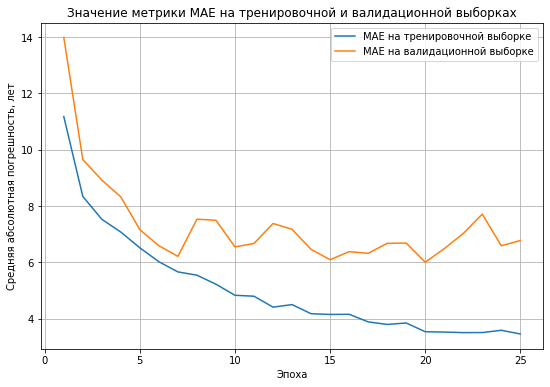

In [13]:
plt.figure(figsize=(9,6))
plt.plot('epoch', 'train_mae', data=results, label="MAE на тренировочной выборке")

plt.plot('epoch', 'validation_mae', data=results, label="MAE на валидационной выборке")

plt.xlabel("Эпоха")
plt.ylabel("Cредняя абсолютная погрешность, лет")
plt.title("Значение метрики MAE на тренировочной и валидационной выборках")
plt.legend()
plt.grid()
plt.show()

Наименьшее значение метрики качества было достигнуто на 20 эпохе и составило 6 лет. Функция, созданная для обучения, вернула именно эту модель. Сводка модели:

```plaintext
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
=================================================================
Total params: 23,854,145
Trainable params: 23,801,025
Non-trainable params: 53,120
_________________________________________________________________
```


**Резюме:**
* Архитектура нейронной сети:
    * предобученная ResNet50 c весами "ImageNet" ("backbone" без "top")
    * пулинг с окном во весь тензор
    * полносвязный слой со 128 нейронами и функцией активации ReLU
    * полносвязный слой с 32 нейронами и функцией активации ReLU
    * полносвязный слой с 1 нейроном и функцией активации ReLU (т.к. возраст не может быть меньше 0)
* Функция потерь - Среднеквадратичная ошибка (MSE)
* Метрика качества - Средняя абсолютная ошибка (MAE)
* Методы аугментации: повороты в пределах 45 градусов, горизонтальные и вертикальные искажения перспектив в пределах 20%.
* Размер батча - 16
* Пороговое значение MAE установленное в задании - 8 лет, эталонное - 5,4.
* Количество эпох обучения для достижения наилучшего качества на валидационной выборке - 20
* Наилучшее значение метрики качества на валидационной выборке - 6 лет.


**Вывод:** Качество предсказаний разработанной модели близко к эталону.


## Общий вывод.

В рамках данного проекта было произведено исследование портретных изображений людей с целью разработки модели, способной определить возраст человека по его фотографии.

Предоставленный набор данных состоит из 7591 изображения и таблицы, в которой указаны имя файла и возраст человека, запечатленного на снимке. Пропусков в таблице не обнаружено.

Изображения включают как цветные, так и черно-белые фотографии, выполненные в различных условиях освещенности и при разных углах наклона камеры. Часть изображений повернуты, предположительно, для выравнивания положения головы по вертикали. На некоторых снимках присутствуют аксессуары, предметы обихода и части лиц других людей. Задний план разнообразен и может быть однородным, неоднородным и размытым.

Анализ таблицы показал, что, хотя на фотографиях можно увидеть людей разного возраста — от одного года до ста лет, большинство из них (72%) — это фотографии взрослых. Детей, подростков и пожилых людей на снимках гораздо меньше: их доля составляет 11%, 12% и 6% соответственно.

Количество предоставленных изображений недостаточно для полноценного обучения нейронной сети, поэтому для решения поставленной задачи был применен метод обучения с переносом опыта и произведена аугментация данных путем поворотов и искажений перспектив. 

В качестве основы была выбрана сверточная нейросеть ResNet50 c весами "ImageNet". К ее базовой архитектуре были добавлены 4 слоя: слой пулинга и 3 полносвязных слоя со 128, 32 и 1 нейроном и функциями активации ReLU. За 20 эпох обучения модель на валидационной выборке достигла значения метрики качества равной 6. Иными словами нейросеть научилась определять возраст человека с точностью ±6 лет. Полученный результат не только удовлетворяет лимитам, указанным в задании (значение MAE на тесте не больше 8), но и достаточно близок к эталонному (MAE = 5.4).
